<a href="https://colab.research.google.com/github/bwood06/EE8603_Final_Project/blob/main/final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EE8603 Final Project - Abalone Regression
### Created by: Brendan Wood - November 29, 2023

Run the following cells in order to perfrom build a regression model to predict the age of Abalone Snails.

## Import libraries
First, import all required python libraries to the notebook.

In [ ]:
!pip install uci-dataset
!pip install pycaret
!pip install pandas
!pip install matplotlib
!pip install scikit-learn
!pip install seaborn
!pip install scipy
!pip install tabulate

## Load Dataset
Next, the dataset must be loaded. The head of the dataset will be printed to ensure the dataset loaded correctly and a heatmap of the dataset's feature correlations will be shown to better describe the dataset.

Below is the head of the dataset to ensure it loaded correctly. 

  Sex  Length  Diameter  Height  Weight.whole  Weight.shucked  Weight.viscera  \
0   M   0.455     0.365   0.095        0.5140          0.2245          0.1010   
1   M   0.350     0.265   0.090        0.2255          0.0995          0.0485   
2   F   0.530     0.420   0.135        0.6770          0.2565          0.1415   
3   M   0.440     0.365   0.125        0.5160          0.2155          0.1140   
4   I   0.330     0.255   0.080        0.2050          0.0895          0.0395   

   Weight.shell  Rings  
0         0.150     15  
1         0.070      7  
2         0.210      9  
3         0.155     10  
4         0.055      7  

----------

Feature           Mean    Standard Deviation
--------------  ------  --------------------
Length            0.52                  0.12
Diameter          0.41                  0.1
Height            0.14                  0.04
Weight.whole      0.83                  0.49
Weight.shucked 

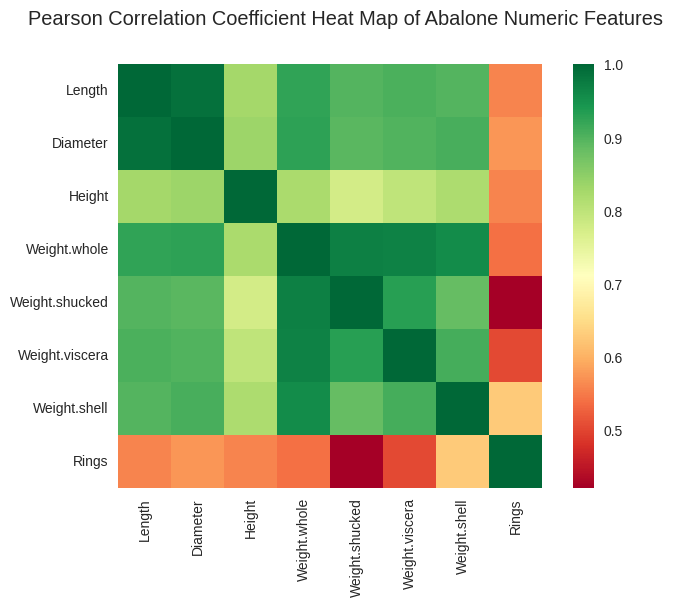

In [60]:
import seaborn as sns
import numpy as np
from uci_dataset import load_abalone
from matplotlib import pyplot as plt
from tabulate import tabulate

dataset = load_abalone()
print(f'Below is the head of the dataset to ensure it loaded correctly. \n')
print(dataset.head())
print('\n----------\n')
table_vals = []
for col in dataset.columns.to_list():
  if col == 'Sex':
    continue
  table_vals.append([col, f'{np.mean(dataset[col]): .2f}', f'{np.std(dataset[col]):.2f}'])
print(tabulate(table_vals, headers=['Feature', 'Mean', 'Standard Deviation']))
print('\n----------\n')
print(f'There are {dataset.shape[0]} samples.')
print('\n----------\n')
print(f'There are {dataset.shape[1] - 1} features that can be used for prediction. The features and their data types are listed below: \n')
print(dataset.dtypes)
print(f'\nThere are {dataset.select_dtypes(exclude=object).shape[1] - 1} numeric features and {dataset.select_dtypes(include=object).shape[1]} categorical feature.' \
      f'There are {len(dataset["Sex"].unique())} options for the categorical variable.')
print(f'After one hot encoding, there will be a total of {dataset.shape[1] - 1 + 2} features that can be used for prediction.')
print('\n----------\n')
print('Below is a Pearson Correlation Coefficient heat map of all the features, from this we can predict which features will be the most important.')
print('Given the larger the coefficient, the stronger the correlation, it can be hypothesized that the weight of the shell will be the strongest predictor. \n')
sns.heatmap(dataset.corr(numeric_only=True, method='pearson'), square=True, cmap='RdYlGn')
plt.suptitle('Pearson Correlation Coefficient Heat Map of Abalone Numeric Features')
plt.show()

## Preprocessing
The below code creates a training object with various preprocessing settings. It outlines the target variable, the proportion of samples to use for training, which cateogrical features to one-hot encode, and the number of folds to use in k-fold cross validation. It also adds a normalized MSE metric to the experiment for accurate comparsion to the literature.

In [61]:
from pycaret.regression import RegressionExperiment
from sklearn.metrics import mean_squared_error

# # First set the target variable to rings +1.5, since that is how age is determined
dataset['Rings'] += 1.5

# Next build the experiment object with the required arguments
exp = RegressionExperiment()
exp.setup(dataset,
          target='Rings',
          train_size=0.8,
          categorical_features=['Sex'],
          fold=5,
          session_id=123)

# Since the papers cited used a normalized version of the mean squared error, create a lambda function that normalizes the sklearn mean_squared_error
# by the variance of the output space.
norm_mse = lambda y_true, y_pred: mean_squared_error(y_true, y_pred) / (dataset['Rings'].std() ** 2)

# Add the metric to the experiment and call it Normalized MSE
_ = exp.add_metric('norm_mse', 'Normalized MSE', norm_mse, greater_is_better=False)

,Description,Value
0,Session id,123
1,Target,Rings
2,Target type,Regression
3,Original data shape,"(4177, 9)"
4,Transformed data shape,"(4177, 11)"
5,Transformed train set shape,"(3341, 11)"
6,Transformed test set shape,"(836, 11)"
7,Numeric features,7
8,Categorical features,1
9,Preprocess,True


## Train the Model
This cell of code trains all types of regression models and selects the overall best performing model to use as the final model. Note that even though the highest Normalized MSE is highlighted, this is a visual error and the best performing Normalzied MSE is at the top of the table.

In [62]:
best = exp.compare_models(sort='Normalized MSE')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,Normalized MSE,TT (Sec)
gbr,Gradient Boosting Regressor,1.5338,4.7272,2.1729,0.5482,0.1548,0.1307,0.4547,0.4300
rf,Random Forest Regressor,1.5570,4.8099,2.1914,0.5400,0.1566,0.1330,0.4627,1.7360
lightgbm,Light Gradient Boosting Machine,1.5551,4.8459,2.2000,0.5368,0.1567,0.1322,0.4662,1.3880
ridge,Ridge Regression,1.5994,4.9445,2.2230,0.5277,0.1641,0.1375,0.4756,0.0680
et,Extra Trees Regressor,1.5814,4.9734,2.2287,0.5246,0.1591,0.1352,0.4784,0.6060
br,Bayesian Ridge,1.5970,4.9767,2.2298,0.5246,0.1633,0.1373,0.4787,0.0680
lr,Linear Regression,1.5986,4.9915,2.2331,0.5232,0.1634,0.1374,0.4802,1.0920
huber,Huber Regressor,1.5660,5.0556,2.2479,0.5173,0.1625,0.1302,0.4863,0.1140
knn,K Neighbors Regressor,1.5921,5.0923,2.2556,0.5133,0.1608,0.1338,0.4899,0.1000
xgboost,Extreme Gradient Boosting,1.6452,5.3464,2.3103,0.4887,0.1653,0.1399,0.5143,0.1860


Processing:   0%|          | 0/81 [00:00<?, ?it/s]

## Analyzing the Selected Model

Below are a series plots illustrating the performance and the best model.

### Residuals
The plot below shows the models residuals as a function of predicted value.

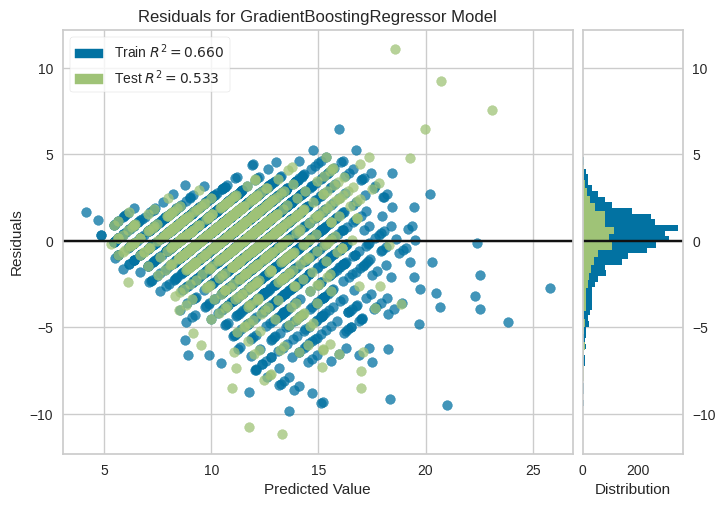

In [63]:
exp.plot_model(best, plot='residuals')

### Feature Importance
The plot below shows which features have the highest importance when predicting the age of the Abalone. All features are shown.

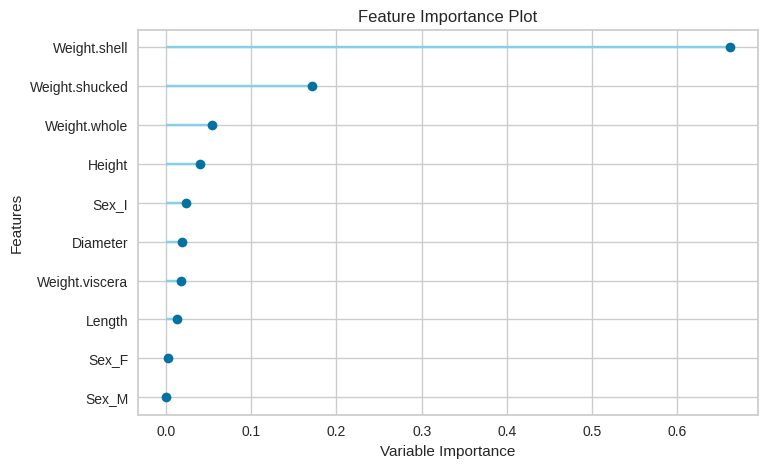

In [64]:
exp.plot_model(best, plot='feature_all')

### Error Plot
The final plot shows the predicted age as a function of actual age. A perfect model would have all points along the identity line.

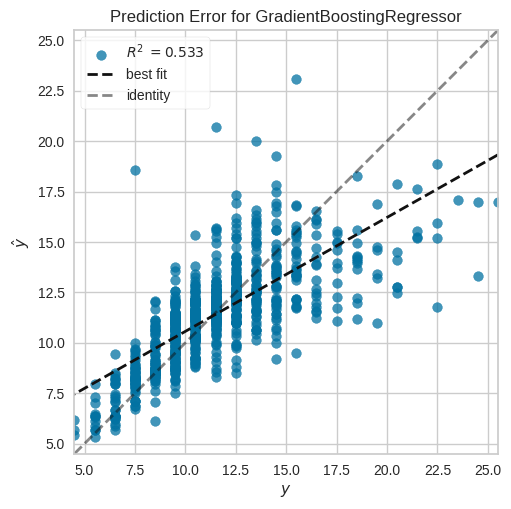

In [65]:
exp.plot_model(best, plot='error')